# Encode Prior Knowledge of $A$ and $A^{-1}$

This tutorial illustrates how to encode prior knowledge of the system matrix $A$ and its inverse $H=A^{-1}$. 

It further discusses connections to classic pre-conditioning. 


In [1]:
import warnings
warnings.filterwarnings('ignore')

# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm 

plt.style.use("../../probnum.mplstyle")

## Prior Knowledge in Linear Systems

Consider a linear system of the form $A \mathbf{x} = \mathbf{b}$ where $A\in\mathbb{R}^{n\times n}$ is a symmetric positive definite matrix, $\mathbf{b}\in\mathbb{R}^n$ is a vector and $\mathbf{x}\in\mathbb{R}^n$ is the unknown solution of the linear system.

Occasionally we have access to prior knowledge about the matrix $A$ or it's inverse $H=A^{-1}$ for example from previously solving a similar linear system, or because we know some quantity related to the eigenspectra of $A$ or $H$, such as an estimate of the largest eigenvalue, the condition number or the mean eigenvalue.
Here, we will first solve a liner system with ProbNum's solver *not* using the available prior knowledge, and then we will solve the system using some available prior knowledge. In particular, we will encode the approximate average eigenvalues of $H$ ANYTHING ELSE.  Finally, we briefly discuss connections to classic methods such as preconditioning.

We begin by creating a random $n=25$ dimensional linear system with ProbNum's `problem.zoo` package. We also specify the eigenspectrum of $A$.

In [2]:
import numpy as np
from probnum.problems.zoo.linalg import random_spd_matrix

rng = np.random.default_rng(42)  # for reproducibility
n = 25  # dimensionality

# generate linear system
spectrum = 10 * np.linspace(0.5, 1, n) ** 4
A = random_spd_matrix(rng=rng, dim=n, spectrum=spectrum)
b = rng.normal(size=(n, 1))

print("Matrix condition: {:.2f}".format(np.linalg.cond(A)))
print("Eigenvalues: {}".format(np.linalg.eigvalsh(A)))

Matrix condition: 16.00
Eigenvalues: [ 0.625       0.73585981  0.8608519   1.00112915  1.15788966  1.33237674
  1.52587891  1.73972989  1.97530864  2.23403931  2.51739125  2.82687905
  3.1640625   3.53054659  3.92798153  4.35806274  4.82253086  5.32317173
  5.86181641  6.44034115  7.06066744  7.72476196  8.43463662  9.19234853
 10.        ]


## Solve the Linear System: Without using Prior Knowledge

We now use ProbNum's probabilistic linear solver `problinsolve` to estimate the solution vector $\mathbf{x}$.
We do not run the solver to convergence (which would require 25 iterations) but only run it for `maxiter`=10 iterations. The only prior knowledge which is encoded here is the fact that $A$ is symmetric (it is not explicitly stated in the cell below, but the solver encodes it), and that the matrix has only positive eigenvalues. 

In [3]:
from probnum.linalg import problinsolve

# Solve with probabilistic linear solver
x, Ahat, Ainv, info = problinsolve(A=A, b=b, maxiter=10)
print(info)

{'iter': 10, 'maxiter': 10, 'resid_l2norm': 0.022193410186189838, 'trace_sol_cov': 27.593259516810043, 'conv_crit': 'maxiter', 'rel_cond': None}


### Illustration of Uncertainty for $A$ and $H$

The solver returns random variables $\mathsf{x}$, $\mathsf{A}$ and $\mathsf{H}:=\mathsf{A}^{-1}$, which quantify numerical uncertainty in the solution, the linear operator itself and the estimate of the inverse respectively.


We plot the mean $\mathbb{E}(\mathsf{A})$ of the random variable $\mathsf{A}$, two samples $\mathsf{A}_1$ and $\mathsf{A}_2$ as well as the ground truth $A$; analogously for $\mathsf{H}$  below. The mean $\mathbb{E}(\mathsf{A})$ is an appropriate estimate of $A$

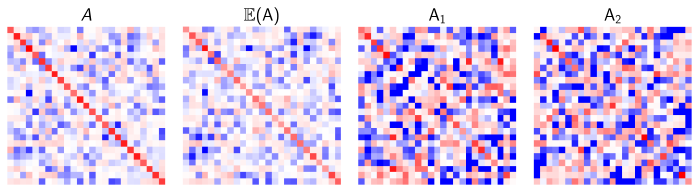

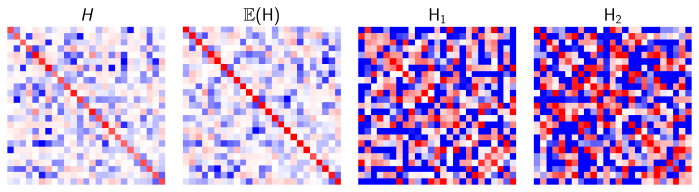

In [4]:
vmax = np.max(A)
vmin = np.min(A)

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Draw samples
rng = np.random.default_rng(seed=42)
Ahat_samples = Ahat.sample(rng=rng, size=3)
Ainv_samples = Ainv.sample(rng=rng, size=3)

# Plot
rvdict = {
    "$A$": A,
    "$\mathbb{E}(\mathsf{A})$": Ahat.mean.todense(),
    "$\mathsf{A}_1$": Ahat_samples[0],
    "$\mathsf{A}_2$": Ahat_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 3), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr", norm=norm)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

H = np.linalg.inv(A)
vmax = np.max(H)
vmin = np.min(H)

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot
rvdict = {
    "$H$": H,
    "$\mathbb{E}(\mathsf{H})$": Ainv.mean.todense(),
    "$\mathsf{H}_1$": Ainv_samples[0],
    "$\mathsf{H}_2$": Ainv_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 3), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr", norm=norm)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

We also plot the product of the last row above (H-quantities) with the true $A$ to illustrate how well the solver approximates the inverse matrix $H$.

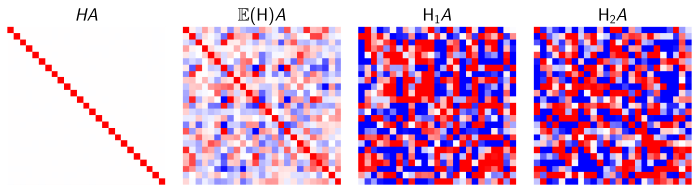

In [5]:
vmax = 1
vmin = -1

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot
rvdict = {
    "$H": np.linalg.inv(A),
    "$\mathbb{E}(\mathsf{H})": Ainv.mean.todense(),
    "$\mathsf{H}_1": Ainv_samples[0],
    "$\mathsf{H}_2": Ainv_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 6), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv @ A, vmin=vmin, vmax=vmax, cmap="bwr", norm=norm)
    axes[i].set_axis_off()
    axes[i].title.set_text(title + "A$")
plt.tight_layout()

## Encode Prior Knowledge: Approximate avg Eigenvalue of $H$

Occasionally, we have access to prior information about the inverse of $A$. For instance, suppose we know an approximate average eigenvalue  $\bar{\lambda}=\text{avg}(\lambda(H))$. In our case this value is about 0.5.
Such knowledge is for example available for large Gram matrices generated by a specific kernel. 


In [6]:
# Average eigenvalue of inverse is approximatley 0.5
print(np.mean(1 / spectrum))

0.4828603473100369


We encode this prior information probabilistically via a matrix random variable $\mathsf{A}^{-1}_0$. We use a random variable as we usually do know the exact value of $\bar{\lambda}$ and also because the average eigenvalue does not entirely describe the matrix $H$. The random variable is called `Ainv0` in the cell below, where the `0` in the name indicates that this is a prior guess for $H$. In essence we will encode a prior for $H$ which has mean $\bar{\lambda}I$ and a `SymmetricKronecker` covariance.

We then solve the linear system again with `maxiter`=10 as before.

In [7]:
import probnum.randvars as randvars
from probnum.linops import Identity, Scaling, SymmetricKronecker

# Prior distribution on A^{-1}
W0H = Identity(n)
covA = SymmetricKronecker(W0H)
approx_avg_eigenvalues = 0.5
Ainv0 = randvars.Normal(mean=Scaling(approx_avg_eigenvalues, shape=(n, n)), cov=covA)

# Solve with probabilistic linear solver using prior information
x, Ahat, Ainv, info = problinsolve(A=A, b=b, Ainv0=Ainv0, maxiter=10)
print(info)

{'iter': 10, 'maxiter': 10, 'resid_l2norm': 0.018257718674779048, 'trace_sol_cov': 23.854200758409913, 'conv_crit': 'maxiter', 'rel_cond': None}


## Illustration of Uncertainty for $A$ and $H$ using Prior Information

We again plot the mean $\mathbb{E}(\mathsf{A})$ of the random variable $\mathsf{A}$, two samples $\mathsf{A}_1$ and $\mathsf{A}_2$ as well as the ground truth $A$; analogously for $\mathsf{H}$  below. The color-scales are the same as in their analogous plots above.

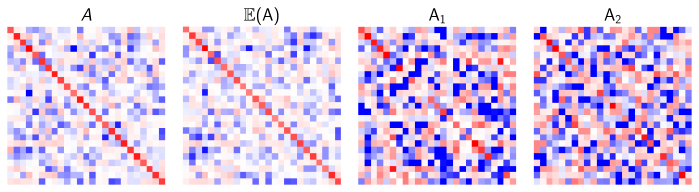

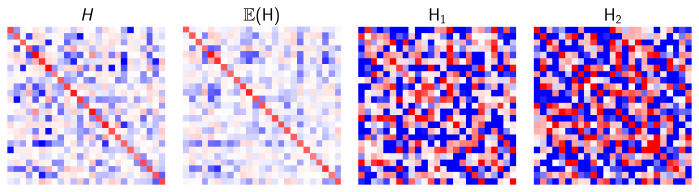

In [8]:
vmax = np.max(A)
vmin = np.min(A)

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Draw samples
rng = np.random.default_rng(seed=42)
Ahat_samples = Ahat.sample(rng=rng, size=3)
Ainv_samples = Ainv.sample(rng=rng, size=3)

# Plot
rvdict = {
    "$A$": A,
    "$\mathbb{E}(\mathsf{A})$": Ahat.mean.todense(),
    "$\mathsf{A}_1$": Ahat_samples[0],
    "$\mathsf{A}_2$": Ahat_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 3), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr", norm=norm)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

vmax = np.max(H)
vmin = np.min(H)

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot
rvdict = {
    "$H$": H,
    "$\mathbb{E}(\mathsf{H})$": Ainv.mean.todense(),
    "$\mathsf{H}_1$": Ainv_samples[0],
    "$\mathsf{H}_2$": Ainv_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 3), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv, vmin=vmin, vmax=vmax, cmap="bwr", norm=norm)
    axes[i].set_axis_off()
    axes[i].title.set_text(title)
plt.tight_layout()

Again, we plot the product of the last row above (H-quantities) with the true $A$ to illustrate how well the solver approximates the inverse matrix $H$.

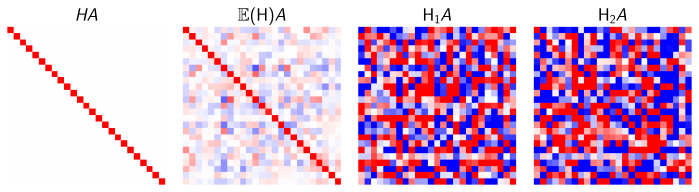

In [9]:
vmax = 1
vmin = -1

# normalize diverging colobar, such that it is centered at zero
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot
rvdict = {
    "$H": np.linalg.inv(A),
    "$\mathbb{E}(\mathsf{H})": Ainv.mean.todense(),
    "$\mathsf{H}_1": Ainv_samples[0],
    "$\mathsf{H}_2": Ainv_samples[1],
}

fig, axes = plt.subplots(nrows=1, ncols=len(rvdict), figsize=(10, 6), sharey=True)
for i, (title, rv) in enumerate(rvdict.items()):
    axes[i].imshow(rv @ A, vmin=vmin, vmax=vmax, cmap="bwr", norm=norm)
    axes[i].set_axis_off()
    axes[i].title.set_text(title + "A$")
plt.tight_layout()

Even though the solver has only explored a subspace of dimension $k \ll n$, the mean estimates for the matrix and its inverse are already close. This is in part due to the informative prior that we used. We can see that the uncertainty of the solver about these quantities is still relatively high by looking at the samples from $\mathsf{A}$ and $\mathsf{H}$ .

THE ESTIMATE OF X GETS WORSE THOUGH


## Connections to Preconditioning

TBD.

## References

[1] J. Wenger & P. Hennig, *Probabilistic Linear Solvers for Machine Learning*, 34th Conference on Neural Information Processing Systems (NeurIPS), 2020.